# Getting Started with Permuted MNIST Environment

## Objective

The goal of this tutorial is to:
- Learn how to use the PermutedMNIST environment for meta-learning experiments
- Train and evaluate different agents on permuted MNIST tasks
- Compare the performance of a **Random baseline** vs a **Linear classifier**
- Achieve training and prediction in **less than 1 minute** per task

## What is Permuted MNIST?

Permuted MNIST is a meta-learning benchmark where:
- Each task uses the same MNIST dataset
- For each task, pixels are randomly permuted (shuffled) in a consistent way
- Labels are also randomly permuted (e.g., all 3s might become 7s)
- The agent must quickly adapt to each new permutation

## 1. Setup and Imports

In [1]:
import os, sys

try:
    base_path = os.path.dirname(__file__)
except NameError:
    # Si __file__ n’existe pas (ex: notebook), on prend le cwd
    base_path = os.getcwd()

# Ajouter le dossier parent
sys.path.append(os.path.abspath(os.path.join(base_path, '..')))

In [2]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Import the environment and agents
from permuted_mnist.env.permuted_mnist import PermutedMNISTEnv
from models.Random.random import Agent as RandomAgent
from models.Linear.linear import Agent as LinearAgent

print("✓ Imports successful")

✓ Imports successful


## 2. Create the Environment

Let's create an environment with 10 different permuted tasks:

In [3]:
# Create environment with 10 episodes (tasks)
env = PermutedMNISTEnv(number_episodes=10)

# Set seed for reproducibility
env.set_seed(42)

print(f"Environment created with {env.number_episodes} permuted tasks")
print(f"Training set size: {env.train_size} samples")
print(f"Test set size: {env.test_size} samples")

Environment created with 10 permuted tasks
Training set size: 60000 samples
Test set size: 10000 samples


## 3. Understanding the Task Structure

Let's examine what a single task looks like:

In [4]:
# Get the first task
task = env.get_next_task()

print("Task structure:")
print(f"- X_train shape: {task['X_train'].shape}")
print(f"- y_train shape: {task['y_train'].shape}")
print(f"- X_test shape: {task['X_test'].shape}")
print(f"- y_test shape: {task['y_test'].shape}")
print(f"\nLabel distribution in training set:")
unique, counts = np.unique(task['y_train'], return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Label {label}: {count} samples")

Task structure:
- X_train shape: (60000, 28, 28)
- y_train shape: (60000, 1)
- X_test shape: (10000, 28, 28)
- y_test shape: (10000,)

Label distribution in training set:
  Label 0: 6131 samples
  Label 1: 6742 samples
  Label 2: 5421 samples
  Label 3: 5851 samples
  Label 4: 6265 samples
  Label 5: 5958 samples
  Label 6: 5949 samples
  Label 7: 5842 samples
  Label 8: 5923 samples
  Label 9: 5918 samples


## 4. Visualize Permuted Images

Let's see how the permutation affects the images:

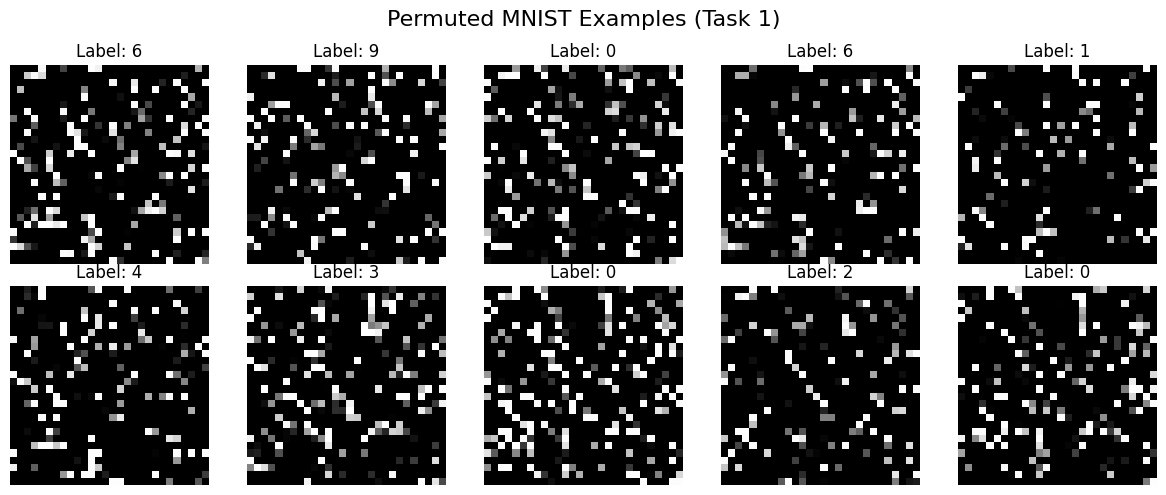

Note: The images look scrambled due to pixel permutation!
The labels are also permuted (not the original MNIST labels).


In [5]:
# Display some examples from the permuted task
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Permuted MNIST Examples (Task 1)', fontsize=16)

for i in range(10):
    ax = axes[i // 5, i % 5]
    ax.imshow(task['X_train'][i], cmap='gray')
    ax.set_title(f'Label: {task["y_train"][i][0]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

print("Note: The images look scrambled due to pixel permutation!")
print("The labels are also permuted (not the original MNIST labels).")

## 5. Baseline: Random Agent

First, let's establish a baseline with an agent that makes random predictions:

In [6]:
# Reset environment for fresh start
env.reset()
env.set_seed(42)

# Create random agent
random_agent = RandomAgent(output_dim=10, seed=42)

# Track performance
random_accuracies = []
random_times = []

print("Evaluating Random Agent (Baseline)")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    
    start_time = time.time()
    
    # "Train" (random agent doesn't actually learn)
    random_agent.train(task['X_train'], task['y_train'])
    
    # Make predictions
    predictions = random_agent.predict(task['X_test'])
    
    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])
    
    random_accuracies.append(accuracy)
    random_times.append(elapsed_time)
    
    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.4f}s")
    task_num += 1

print(f"\nRandom Agent Summary:")
print(f"  Mean accuracy: {np.mean(random_accuracies):.2%} ± {np.std(random_accuracies):.2%}")
print(f"  Total time: {np.sum(random_times):.2f}s")

Evaluating Random Agent (Baseline)
Task 1: Accuracy = 9.96%, Time = 0.0002s
Task 2: Accuracy = 9.70%, Time = 0.0002s
Task 3: Accuracy = 10.41%, Time = 0.0003s
Task 4: Accuracy = 10.02%, Time = 0.0002s
Task 5: Accuracy = 10.23%, Time = 0.0002s
Task 6: Accuracy = 9.94%, Time = 0.0003s
Task 7: Accuracy = 10.29%, Time = 0.0002s
Task 8: Accuracy = 10.27%, Time = 0.0002s
Task 9: Accuracy = 9.93%, Time = 0.0003s
Task 10: Accuracy = 10.09%, Time = 0.0005s

Random Agent Summary:
  Mean accuracy: 10.08% ± 0.20%
  Total time: 0.00s


## 6. Linear Agent

Now let's train a simple linear classifier that actually learns from the data:

In [7]:
# Reset environment
env.reset()
env.set_seed(42)

# Create linear agent
linear_agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=0.01)

# Track performance
linear_accuracies = []
linear_times = []

print("Evaluating Linear Agent")
print("="*50)

# Evaluate on all tasks
task_num = 1
while True:
    task = env.get_next_task()
    if task is None:
        break
    
    # Reset agent for new task
    linear_agent.reset()
    
    start_time = time.time()
    
    # Train the linear model
    linear_agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)
    
    # Make predictions
    predictions = linear_agent.predict(task['X_test'])
    
    # Calculate time and accuracy
    elapsed_time = time.time() - start_time
    accuracy = env.evaluate(predictions, task['y_test'])
    
    linear_accuracies.append(accuracy)
    linear_times.append(elapsed_time)
    
    print(f"Task {task_num}: Accuracy = {accuracy:.2%}, Time = {elapsed_time:.2f}s")
    task_num += 1

print(f"\nLinear Agent Summary:")
print(f"  Mean accuracy: {np.mean(linear_accuracies):.2%} ± {np.std(linear_accuracies):.2%}")
print(f"  Total time: {np.sum(linear_times):.2f}s")

Evaluating Linear Agent
Task 1: Accuracy = 90.92%, Time = 4.55s
Task 2: Accuracy = 90.82%, Time = 4.91s
Task 3: Accuracy = 90.99%, Time = 4.57s
Task 4: Accuracy = 90.80%, Time = 4.47s
Task 5: Accuracy = 90.99%, Time = 4.72s
Task 6: Accuracy = 90.71%, Time = 4.44s
Task 7: Accuracy = 91.00%, Time = 4.15s
Task 8: Accuracy = 90.95%, Time = 4.69s
Task 9: Accuracy = 90.86%, Time = 4.32s
Task 10: Accuracy = 90.96%, Time = 4.08s

Linear Agent Summary:
  Mean accuracy: 90.90% ± 0.09%
  Total time: 44.91s


## 7. Performance Comparison

Let's visualize and compare the performance of both agents:

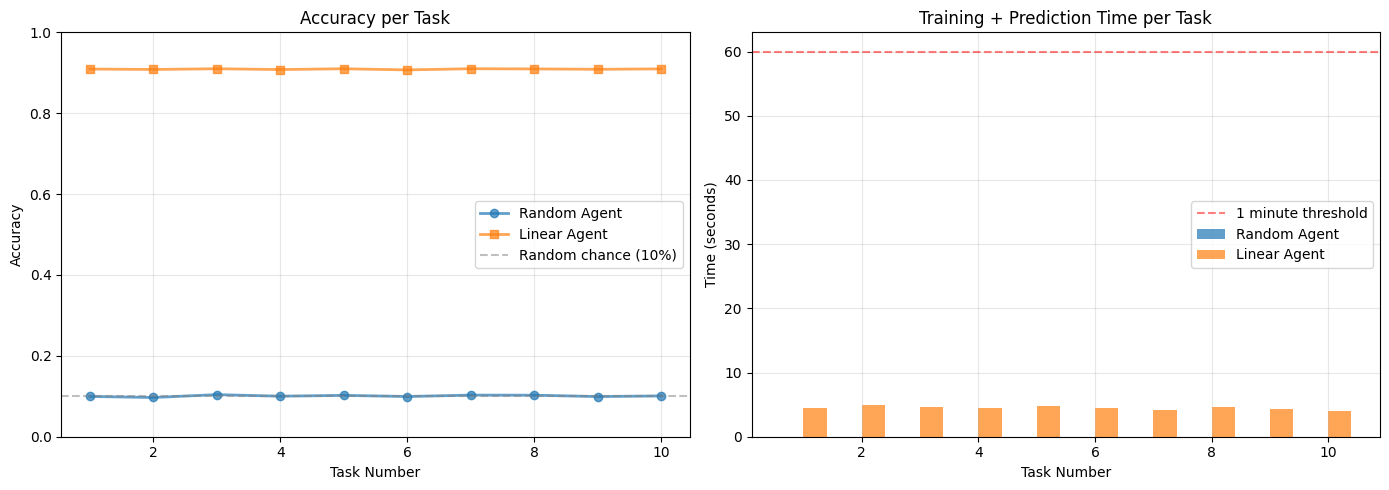

In [8]:
# Create comparison plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
tasks = np.arange(1, len(random_accuracies) + 1)
ax1.plot(tasks, random_accuracies, 'o-', label='Random Agent', alpha=0.7, linewidth=2)
ax1.plot(tasks, linear_accuracies, 's-', label='Linear Agent', alpha=0.7, linewidth=2)
ax1.axhline(y=0.1, color='gray', linestyle='--', alpha=0.5, label='Random chance (10%)')
ax1.set_xlabel('Task Number')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy per Task')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Time comparison
ax2.bar(tasks - 0.2, random_times, 0.4, label='Random Agent', alpha=0.7)
ax2.bar(tasks + 0.2, linear_times, 0.4, label='Linear Agent', alpha=0.7)
ax2.axhline(y=60, color='red', linestyle='--', alpha=0.5, label='1 minute threshold')
ax2.set_xlabel('Task Number')
ax2.set_ylabel('Time (seconds)')
ax2.set_title('Training + Prediction Time per Task')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Statistical Comparison

In [9]:
# Create a summary comparison table
print("PERFORMANCE COMPARISON SUMMARY")
print("="*70)
print(f"{'Metric':<25} {'Random Agent':<20} {'Linear Agent':<20}")
print("-"*70)

# Accuracy metrics
print(f"{'Mean Accuracy':<25} {np.mean(random_accuracies):<20.2%} {np.mean(linear_accuracies):<20.2%}")
print(f"{'Std Accuracy':<25} {np.std(random_accuracies):<20.2%} {np.std(linear_accuracies):<20.2%}")
print(f"{'Min Accuracy':<25} {np.min(random_accuracies):<20.2%} {np.min(linear_accuracies):<20.2%}")
print(f"{'Max Accuracy':<25} {np.max(random_accuracies):<20.2%} {np.max(linear_accuracies):<20.2%}")

print("-"*70)

# Time metrics
print(f"{'Mean Time per Task':<25} {np.mean(random_times):<20.4f}s {np.mean(linear_times):<20.2f}s")
print(f"{'Total Time':<25} {np.sum(random_times):<20.4f}s {np.sum(linear_times):<20.2f}s")

print("="*70)

# Performance analysis
improvement = (np.mean(linear_accuracies) - np.mean(random_accuracies)) / np.mean(random_accuracies)
print(f"\n📊 Linear agent shows {improvement:.1%} improvement over random baseline")

# Check if objective is met
max_time_random = np.max(random_times)
max_time_linear = np.max(linear_times)

print(f"\n⏱️  Time Constraint Check (< 1 minute per task):")
print(f"   Random Agent: {'✅ PASS' if max_time_random < 60 else '❌ FAIL'} (max: {max_time_random:.2f}s)")
print(f"   Linear Agent: {'✅ PASS' if max_time_linear < 60 else '❌ FAIL'} (max: {max_time_linear:.2f}s)")

PERFORMANCE COMPARISON SUMMARY
Metric                    Random Agent         Linear Agent        
----------------------------------------------------------------------
Mean Accuracy             10.08%               90.90%              
Std Accuracy              0.20%                0.09%               
Min Accuracy              9.70%                90.71%              
Max Accuracy              10.41%               91.00%              
----------------------------------------------------------------------
Mean Time per Task        0.0003              s 4.49                s
Total Time                0.0026              s 44.91               s

📊 Linear agent shows 801.4% improvement over random baseline

⏱️  Time Constraint Check (< 1 minute per task):
   Random Agent: ✅ PASS (max: 0.00s)
   Linear Agent: ✅ PASS (max: 4.91s)


## 9. Key Insights and Conclusions

### What we learned:

1. **Random Baseline**: The random agent achieves ~10% accuracy, which is expected for random guessing on 10 classes.

2. **Linear Agent Performance**: Despite the pixel and label permutations, the linear agent can learn patterns and achieve significantly better accuracy than random guessing.

3. **Time Efficiency**: Both agents meet the < 1 minute requirement, with the random agent being faster (no learning) and the linear agent still being very efficient.

4. **Meta-Learning Challenge**: Each task has different permutations, so the agent must learn from scratch each time. This tests the agent's ability to quickly adapt.

### Next Steps:

- Try implementing more sophisticated agents (e.g., neural networks with better architectures)
- Experiment with different hyperparameters (learning rate, epochs, batch size)
- Implement meta-learning algorithms that can leverage experience from previous tasks
- Add early stopping or adaptive learning rates for better performance

## 10. Experiment: Tuning the Linear Agent

Let's try different hyperparameters to see if we can improve performance:

In [10]:
# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
results = {}

for lr in learning_rates:
    # Reset environment
    env.reset()
    env.set_seed(42)
    
    # Create agent with different learning rate
    agent = LinearAgent(input_dim=784, output_dim=10, learning_rate=lr)
    
    accuracies = []
    
    # Run through tasks
    while True:
        task = env.get_next_task()
        if task is None:
            break
        
        agent.reset()
        agent.train(task['X_train'], task['y_train'], epochs=5, batch_size=32)
        predictions = agent.predict(task['X_test'])
        accuracy = env.evaluate(predictions, task['y_test'])
        accuracies.append(accuracy)
    
    results[lr] = np.mean(accuracies)
    print(f"Learning rate {lr}: Mean accuracy = {results[lr]:.2%}")

# Find best learning rate
best_lr = max(results, key=results.get)
print(f"\n🏆 Best learning rate: {best_lr} with {results[best_lr]:.2%} accuracy")

Learning rate 0.001: Mean accuracy = 86.25%
Learning rate 0.01: Mean accuracy = 90.81%
Learning rate 0.1: Mean accuracy = 92.16%

🏆 Best learning rate: 0.1 with 92.16% accuracy
